<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Format-data" data-toc-modified-id="Format-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Format data</a></span></li><li><span><a href="#Host-tree-subsample" data-toc-modified-id="Host-tree-subsample-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Host tree subsample</a></span></li><li><span><a href="#Creating-PCs-for-each-tree" data-toc-modified-id="Creating-PCs-for-each-tree-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Creating PCs for each tree</a></span></li><li><span><a href="#PGLS" data-toc-modified-id="PGLS-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>PGLS</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Diet" data-toc-modified-id="Diet-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Diet</a></span><ul class="toc-item"><li><span><a href="#Weighted-Unifrac" data-toc-modified-id="Weighted-Unifrac-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>Weighted Unifrac</a></span></li><li><span><a href="#Unweighted-Unifrac" data-toc-modified-id="Unweighted-Unifrac-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>Unweighted Unifrac</a></span></li></ul></li><li><span><a href="#Summarizing" data-toc-modified-id="Summarizing-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Summarizing</a></span></li></ul></li><li><span><a href="#Significant-vars" data-toc-modified-id="Significant-vars-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Significant vars</a></span></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Conduct PGLS on beta-diversity PCoA PCs

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/PGLS/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# beta-div distance matrices
beta_div_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/diversity/beta_div.RDS'

# host phylogeny
host_tree_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_20180625_rn_16S-r5k_IndD.nwk'

# params
threads = 12

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(ape)
library(phyloseq)
library(ade4)
library(ape)
library(caper)
source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: mvtnorm


In [3]:
make_dir(work_dir)
setwd(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/PGLS/ 


## Functions

# Load

In [4]:
# metadata table
metadata = readRDS(physeq_file) %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(X.SampleID = rownames(.)) %>%
    dplyr::select(X.SampleID, scientific_name, diet, 
                  diet_vertebrate,diet_invertebrate,diet_fruit,
                  diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,
                  diet_seeds,diet_grass_waterplants,diet_roots_tubers) %>%
    mutate(scientific_name = gsub(' ', '_', scientific_name)) %>%
    as.data.frame

rownames(metadata) = metadata$SampleID
metadata %>% status

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 213  11


X.SampleID,scientific_name,diet,diet_vertebrate,diet_invertebrate,diet_fruit,diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,diet_seeds,diet_grass_waterplants,diet_roots_tubers
X1.Eurasian.Beaver,Castor_fiber,herbivore,no,no,no,no,yes,no,yes,yes
X101.Horse,Equus_caballus,herbivore,no,no,no,no,no,yes,yes,no
X102.Kulan,Equus_hemionus,herbivore,no,no,no,no,yes,no,yes,no


In [5]:
# host tree file
host_tree = read.tree(host_tree_file)
host_tree


Phylogenetic tree with 213 tips and 177 internal nodes.

Tip labels:
	X256.Zander, F302.Northern.Pike, X188.Brook.Trout, F300.Asp, X330.Ide, X327.Silver.Bream, ...
Node labels:
	, @_22_@, @_8_@, @_7_@, @_20_@, @_17_@, ...

Rooted; includes branch lengths.

In [6]:
# load beta-diversity dist. matrices
beta_d = readRDS(beta_div_file)

# status
lapply(beta_d, function(x) x %>% as.vector %>% summary)

$bray_curtis
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1104  0.9984  1.0000  0.9890  1.0000  1.0000 

$jaccard
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3886  0.9956  1.0000  0.9912  1.0000  1.0000 

$unweighted_unifrac
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2149  0.7783  0.8494  0.8361  0.9163  0.9881 

$weighted_unifrac
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02332 0.46492 0.55024 0.53904 0.62490 0.94211 


# Format data

In [7]:
diet_vars = c(
'X.SampleID',
'diet',
'diet_vertebrate',
'diet_invertebrate',
'diet_fruit',
'diet_flowers_nectar_pollen',
'diet_leaves_branches_bark_buds',
'diet_seeds',
'diet_grass_waterplants',
'diet_roots_tubers'
)
meta_f = metadata[,diet_vars]
#rownames(meta_f) = meta_f$X.SampleID
#meta_f$X.SampleID = NULL
meta_f %>% status

[1] 213  10


X.SampleID,diet,diet_vertebrate,diet_invertebrate,diet_fruit,diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,diet_seeds,diet_grass_waterplants,diet_roots_tubers
X1.Eurasian.Beaver,herbivore,no,no,no,no,yes,no,yes,yes
X101.Horse,herbivore,no,no,no,no,no,yes,yes,no
X102.Kulan,herbivore,no,no,no,no,yes,no,yes,no


In [8]:
# transforming
meta_f$diet = ifelse(meta_f$diet == 'herbivore', 1,
                        ifelse(meta_f$diet == 'omnivore', 0.5, 0))

for(x in diet_vars[3:length(diet_vars)]){
    meta_f[,x] = gsub(' .+', '', meta_f[,x])
    meta_f[,x] = ifelse(meta_f[,x] == 'yes', 1, 0) %>% as.numeric
}

meta_f %>% status

[1] 213  10


X.SampleID,diet,diet_vertebrate,diet_invertebrate,diet_fruit,diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,diet_seeds,diet_grass_waterplants,diet_roots_tubers
X1.Eurasian.Beaver,1,0,0,0,0,1,0,1,1
X101.Horse,1,0,0,0,0,0,1,1,0
X102.Kulan,1,0,0,0,0,1,0,1,0


In [9]:
# checking column values
colSums(meta_f[,2:10])

diet                diet_vertebrate 
                           117                             75 
             diet_invertebrate                     diet_fruit 
                           109                             89 
    diet_flowers_nectar_pollen diet_leaves_branches_bark_buds 
                            18                            101 
                    diet_seeds         diet_grass_waterplants 
                            86                             96 
             diet_roots_tubers 
                            70

# Host tree subsample

In [10]:
setdiff(host_tree$tip.label, meta_f$X.SampleID) %>% print
setdiff(meta_f$X.SampleID, host_tree$tip.label) %>% print

character(0)
character(0)


In [11]:
#' randomly selecting one per group
tree_subsample = function(L, df, tree){
    # get subsample (note: subsampling within each species)
    to_keep = df %>% 
        group_by(scientific_name) %>% 
        sample_n(1) %>%
        .$sample
    # subsampling tree
    to_rm = setdiff(tree$tip.label, to_keep)
    tree = drop.tip(tree, to_rm)
    return(tree)
}

In [12]:
# permuted trees
df = metadata %>%
    mutate(sample = X.SampleID) %>%
    dplyr::select(sample, scientific_name) 

doParallel::registerDoParallel(threads)
host_tree_l = plyr::llply(as.list(1:100), 
                          function(x) tree_subsample(x, df, host_tree),
                          .parallel=TRUE)
host_tree_l %>% length

[1] 100

In [13]:
# check tips per tree
lapply(host_tree_l, function(x) x$tip.label %>% length) %>% unlist %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    128     128     128     128     128     128 

# Creating PCs for each tree

* Beta-div PCoA PCs for each subsampled host tree

In [14]:
# check label overlap
setdiff(host_tree$tip.label, labels(beta_d[[1]])) %>% length %>% print
setdiff(labels(beta_d[[1]]), host_tree$tip.label) %>% length %>% print

[1] 0
[1] 0


In [15]:
#' Ordering distance matrixes
#' d = distance matrix (dist class)
#' x = vector to order dist by
dist_mtx_order = function(d, x){
    m = d %>% as.matrix
    d = as.dist(m[x,x])
    return(d)
}

In [16]:
#' coverting pcoa to data.frame
get_points = function(mds_list){
    # pulling out PCoA points
    df = mds_list$points %>% as.data.frame
    df$Sample = rownames(df)
    colnames(df) = c('PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'D', 'Sample')
    return(df)
}

In [17]:
#' pcoa function
.pcoa = function(id, dist_list, make_plot=TRUE){
    # making PCoA plot 
    # id = list name
    # dist_list = list of distance matrixes
    # make_plt = create plot?
    
    d = dist_list[[id]]
    # using cmdscale for getting PCoA
    r = cmdscale(d, k=5, eig=TRUE)
    perc_var_exp = r$eig / sum(r$eig)
    
    x = as.data.frame(r$points)
    x$sampleID = id
    r$points = x
    
    if(make_plot){
        options(repr.plot.width=4, repr.plot.height=3.5)
        x = 1:5
        plot(x, perc_var_exp[x], main=id)
    }
    
    return(r)
}

In [18]:
#' ordering each distance matrix by tree labels
pcoa_each = function(tree, dist_mtx_list){
    # subsampling and ordering
    d = plyr::llply(dist_mtx_list, dist_mtx_order, x=tree$tip.label)
    # calc PCoA
    d = plyr::llply(names(d), .pcoa, dist_list=d, make_plot=FALSE)
    # getting points
    plyr::ldply(d, get_points)
}

In [19]:
# subsampling and ordering each distance matrix for each subsampled host tree
doParallel::registerDoParallel(threads)
beta_d_pcoa = plyr::llply(host_tree_l, pcoa_each, dist_mtx_list=beta_d, .parallel=TRUE)

# status
beta_d_pcoa %>% length %>% print
beta_d_pcoa %>% lapply(nrow) %>% unlist %>% summary
beta_d_pcoa[[1]] %>% head %>% print

[1] 100


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    512     512     512     512     512     512 

          PC1        PC2          PC3         PC4        PC5           D
1 -0.03013887 0.01625948  0.022771741 -0.02720429 0.03248202 bray_curtis
2 -0.05685115 0.04186083  0.007808206 -0.05651493 0.09955970 bray_curtis
3 -0.02599381 0.01428771  0.022491384 -0.03235857 0.02808348 bray_curtis
4 -0.04105296 0.03453252  0.014744670 -0.06654723 0.08426618 bray_curtis
5 -0.08480934 0.07876045 -0.030100473 -0.08049190 0.14299137 bray_curtis
6 -0.07926509 0.07128574 -0.013567891 -0.06105649 0.11804132 bray_curtis
              Sample
1        X256.Zander
2 F302.Northern.Pike
3   X188.Brook.Trout
4           F300.Asp
5           X330.Ide
6  X326.Silver.Bream


In [20]:
# adding metadata
add_metadata = function(d, metadata){
    inner_join(d, metadata, c('Sample' = 'X.SampleID'))
}

beta_d_pcoa = lapply(beta_d_pcoa, add_metadata, metadata=meta_f)

beta_d_pcoa[[1]] %>% status

[1] 512  16


PC1,PC2,PC3,PC4,PC5,D,Sample,diet,diet_vertebrate,diet_invertebrate,diet_fruit,diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,diet_seeds,diet_grass_waterplants,diet_roots_tubers
-0.03013887,0.01625948,0.022771741,-0.02720429,0.03248202,bray_curtis,X256.Zander,0,1,1,0,0,0,0,1,0
-0.05685115,0.04186083,0.007808206,-0.05651493,0.09955970,bray_curtis,F302.Northern.Pike,0,1,0,0,0,0,0,0,0
-0.02599381,0.01428771,0.022491384,-0.03235857,0.02808348,bray_curtis,X188.Brook.Trout,0,1,1,0,0,0,0,0,0


# PGLS

## Functions

In [29]:
pgls_each_var = function(y, x, tree, data, dist_metric){
    data = data[data$D == dist_metric,]
    cdat = comparative.data(data=data, phy=tree, names.col="Sample")
    
    f = as.formula(paste(c(y, x), collapse=' ~ '))
    mod = pgls(f, cdat, lambda=0.5) %>% summary
    
    df = mod$coefficients %>% as.data.frame
    colnames(df) = c('Estimate', 'std_err', 't_value', 'p_value')
    df$R2 = mod$adj.r.squared %>% as.vector %>% .[1]
    df$x = x
    df$y = y
    df = df[2,] %>% as.data.frame
    return(df)
}

In [30]:
#-- debug --#
rep = 1
host_tree = host_tree_l[[rep]]
data = beta_d_pcoa[[rep]]

pgls_each_var(y = 'PC1',
              x = 'diet',
              tree = host_tree,
              data = data,
              dist_metric = 'weighted_unifrac')

,Estimate,std_err,t_value,p_value,R2,x,y
diet,0.1966572,0.03928121,5.006394,1.825983e-06,0.1592966,diet,PC1


In [31]:
pgls_each_tree = function(rep, y, x, tree_list, data, dist_metric, threads=1){
    tree = tree_list[[rep]]
    data = data[[rep]] 
    
    doParallel::registerDoParallel(threads)
    ret = plyr::llply(as.list(y),
                      pgls_each_var,
                      x = 'diet',
                      tree = tree,
                      data = data,
                      dist_metric = dist_metric,
                      .parallel = TRUE)
    ret = do.call(rbind, ret)
    ret$rep = rep
    return(ret)
}

In [32]:
#-- debug --#
y = c('PC1', 'PC2', 'PC3', 'PC4', 'PC5')

rep = 10
ret = pgls_each_tree(rep,
                     y = y,
                     x = 'diet',
                     tree_list = host_tree_l,
                     data = beta_d_pcoa,
                     dist_metric = 'weighted_unifrac',
                     threads = threads)

ret = do.call(rbind, ret) %>%
    as.data.frame
colnames(ret) = y

ret 

,PC1,PC2,PC3,PC4,PC5
Estimate,0.183927557698656,0.0620313292852116,-0.0969283162631423,-0.000932002529047578,0.059259880419709
std_err,0.0383901909815278,0.0343812967985073,0.031549063593514,0.028327745049352,0.0263335809853556
t_value,4.79100397773891,1.80421726524011,-3.07230406302992,-0.0329006960287119,2.250354042341
p_value,4.58271013248357e-06,0.0735860332619431,0.00260350769915085,0.973805838898492,0.0261605474628221
R2,0.1473861763586,0.0174476534888653,0.0623088549067595,-0.00792784890995911,0.0310084418474974
x,diet,diet,diet,diet,diet
y,PC1,PC2,PC3,PC4,PC5
rep,10,10,10,10,10


## Diet

In [33]:
# dependent variables
y = c('PC1', 'PC2', 'PC3', 'PC4', 'PC5')

### Weighted Unifrac

In [34]:
# running on each PC, each permuted tree
dist_metric = 'weighted_unifrac'

ret = plyr::llply(1:length(host_tree_l),
                  pgls_each_tree,
                  y = y,
                  x = 'diet',
                  tree_list = host_tree_l,
                  data = beta_d_pcoa,
                  dist_metric = dist_metric,
                  threads = threads)

ret = do.call(rbind, ret) %>%
    as.data.frame
rownames(ret) = 1:nrow(ret)
ret$dist_metric = dist_metric

# status
ret %>% status

[1] 500   9


Estimate,std_err,t_value,p_value,R2,x,y,rep,dist_metric
0.19665720,0.03928121,5.006394,1.825983e-06,0.15929659,diet,PC1,1,weighted_unifrac
0.06364587,0.03447111,1.846354,6.718745e-02,0.01861558,diet,PC2,1,weighted_unifrac
-0.07086478,0.03154397,-2.246540,2.641035e-02,0.03088162,diet,PC3,1,weighted_unifrac


In [35]:
# formatting results & adjusting p-values
pgls_res_wUnifrac = ret %>%
    mutate(R2 = R2 %>% as.numeric,
           p_value = p_value %>% as.numeric) %>%
    group_by(rep) %>%
    mutate(p_adj_value = p.adjust(p_value, method='BH')) %>%
    ungroup()

pgls_res_wUnifrac %>% status

[1] 500  10


Estimate,std_err,t_value,p_value,R2,x,y,rep,dist_metric,p_adj_value
0.19665720,0.03928121,5.006394,1.825983e-06,0.15929659,diet,PC1,1,weighted_unifrac,9.129917e-06
0.06364587,0.03447111,1.846354,6.718745e-02,0.01861558,diet,PC2,1,weighted_unifrac,1.119791e-01
-0.07086478,0.03154397,-2.246540,2.641035e-02,0.03088162,diet,PC3,1,weighted_unifrac,6.602588e-02


### Unweighted Unifrac

In [36]:
# running on each PC, each permuted tree
dist_metric = 'unweighted_unifrac'

ret = plyr::llply(1:length(host_tree_l),
                  pgls_each_tree,
                  y = y,
                  x = 'diet',
                  tree_list = host_tree_l,
                  data = beta_d_pcoa,
                  dist_metric = dist_metric,
                  threads = threads)

ret = do.call(rbind, ret) %>%
    as.data.frame
rownames(ret) = 1:nrow(ret)
ret$dist_metric = dist_metric

# status
ret %>% status

[1] 500   9


Estimate,std_err,t_value,p_value,R2,x,y,rep,dist_metric
0.31035786,0.04288455,7.237055,3.967271e-11,0.28801667,diet,PC1,1,unweighted_unifrac
-0.10524538,0.03716542,-2.831809,5.390135e-03,0.05237418,diet,PC2,1,unweighted_unifrac
-0.09428623,0.02928297,-3.219831,1.631689e-03,0.06869178,diet,PC3,1,unweighted_unifrac


In [37]:
# formatting results
pgls_res_uwUnifrac = ret %>%
    mutate(R2 = R2 %>% as.numeric,
           p_value = p_value %>% as.numeric) %>%
    group_by(rep) %>%
    mutate(p_adj_value = p.adjust(p_value, method='BH')) %>%
    ungroup()

pgls_res_uwUnifrac %>% status

[1] 500  10


Estimate,std_err,t_value,p_value,R2,x,y,rep,dist_metric,p_adj_value
0.31035786,0.04288455,7.237055,3.967271e-11,0.28801667,diet,PC1,1,unweighted_unifrac,1.983635e-10
-0.10524538,0.03716542,-2.831809,5.390135e-03,0.05237418,diet,PC2,1,unweighted_unifrac,8.983559e-03
-0.09428623,0.02928297,-3.219831,1.631689e-03,0.06869178,diet,PC3,1,unweighted_unifrac,4.079222e-03


## Summarizing

In [38]:
pgls_res = rbind(pgls_res_wUnifrac, pgls_res_uwUnifrac)
pgls_res %>% status

[1] 1000   10


Estimate,std_err,t_value,p_value,R2,x,y,rep,dist_metric,p_adj_value
0.19665720,0.03928121,5.006394,1.825983e-06,0.15929659,diet,PC1,1,weighted_unifrac,9.129917e-06
0.06364587,0.03447111,1.846354,6.718745e-02,0.01861558,diet,PC2,1,weighted_unifrac,1.119791e-01
-0.07086478,0.03154397,-2.246540,2.641035e-02,0.03088162,diet,PC3,1,weighted_unifrac,6.602588e-02


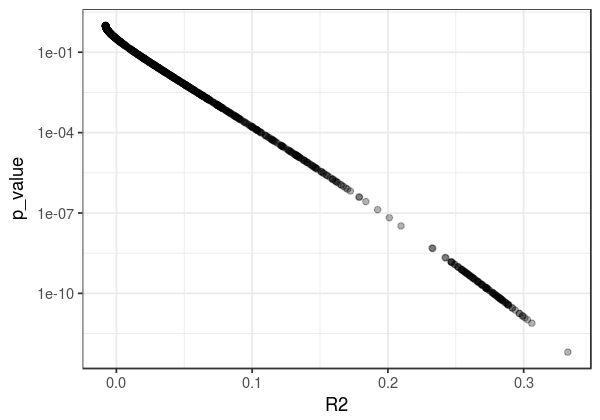

In [39]:
# p-value distribution
p = ggplot(pgls_res, aes(R2, p_value)) +
    geom_point(alpha=0.3) +
    scale_y_log10() +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3.5)
plot(p)

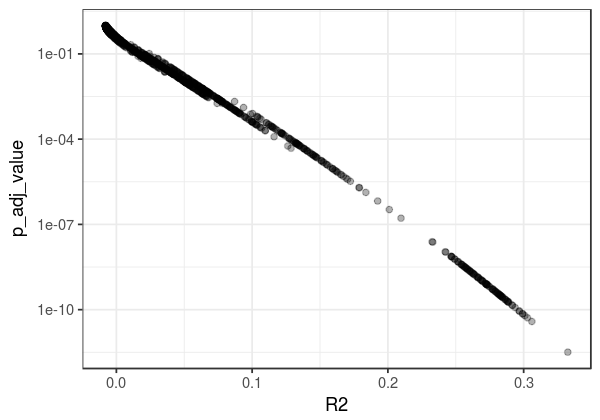

In [40]:
# p-adj-value distribution
p = ggplot(pgls_res, aes(R2, p_adj_value)) +
    geom_point(alpha=0.3) +
    scale_y_log10() +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3.5)
plot(p)

In [41]:
# No. of significant reps for each treatment group
pgls_res %>%
    filter(p_adj_value < 0.05) %>%
    group_by(y, dist_metric) %>%
    summarize(n=n()) %>%
    ungroup()

y,dist_metric,n
PC1,unweighted_unifrac,100
PC1,weighted_unifrac,100
PC2,unweighted_unifrac,90
PC2,weighted_unifrac,55
PC3,unweighted_unifrac,100
PC3,weighted_unifrac,52
PC5,weighted_unifrac,48


# Significant vars

In [45]:
# significant cutoff
pgls_res_sig = pgls_res %>%
    group_by(y, dist_metric) %>%
    summarize(
        qvalue = (length(p_adj_value) - sum(p_adj_value < 0.05)) / length(p_adj_value)
        ) %>%
    ungroup() 

pgls_res_sig$qvalue %>% summary %>% print

pgls_res_sig = pgls_res_sig%>%
    filter(qvalue < 0.05)

pgls_res_sig

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.025   0.465   0.455   0.880   1.000 


y,dist_metric,qvalue
PC1,unweighted_unifrac,0
PC1,weighted_unifrac,0
PC3,unweighted_unifrac,0


File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/PGLS/.figures/pgls_IndD_beta-div-PC_p-val-R2.pdf 


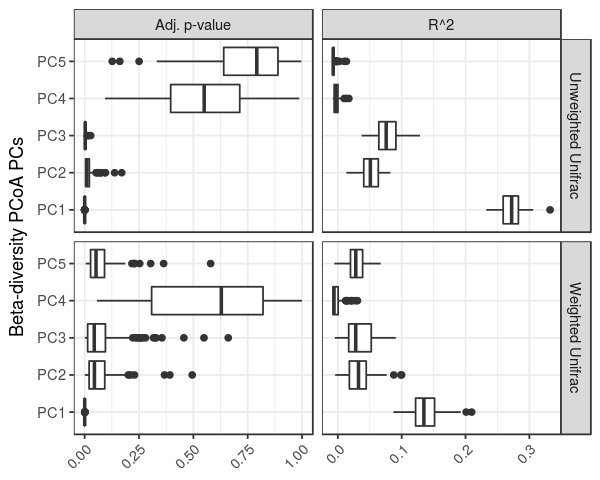

In [47]:
# adj_p-value & R2 dist
tmp = pgls_res %>%
    dplyr::select(y, dist_metric, p_adj_value, R2) %>%
    gather(category, value, -dist_metric, -y) %>%
    mutate(category = ifelse(category == 'R2', 'R^2', 'Adj. p-value'),
           dist_metric = ifelse(dist_metric == 'weighted_unifrac', 
                                'Weighted Unifrac', 'Unweighted Unifrac'))

p = ggplot(tmp, aes(y, value)) +
    geom_boxplot() +
    labs(x='Beta-diversity PCoA PCs') +
    facet_grid(dist_metric ~ category, scales='free_x') +
    coord_flip() +
    theme_bw() +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1)
    )
    
options(repr.plot.width=5, repr.plot.height=4)
plot_write(p, file='pgls_IndD_beta-div-PC_p-val-R2.pdf')

# sessionInfo

In [48]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq_phylo/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq_phylo/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2    caper_1.0.1     mvtnorm_1.0-6   MASS_7.3-48    
 [5] ade4_1.7-10     phyloseq_1.22.3 ape_5.1         ggplot2_2.2.1  
 [9] tidyr_0.8.1     dplyr_0.7.4    

loaded via a namespace (